# Demonstrate Attribution Methods


To determine the impact each variable has on predicting the slope of fPAR/GPP

In [1]:
%matplotlib inline

import sys
import math
import pickle
import warnings
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sb
import scipy.stats
import pymannkendall as mk
import geopandas as gpd
import matplotlib.pyplot as plt
from odc.geo.xr import assign_crs
from odc.geo.geom import Geometry
from scipy.signal import detrend
from scipy.stats import theilslopes, kendalltau
from sklearn.metrics import r2_score
from sklearn.cross_decomposition import PLSRegression

## Analysis Parameters

In [2]:
# k = 'Alice Tableland'
# k = 'Western Mallee'
# k='Daintree-Bloomfield'
k='Warre'
# k = 'Victorian Alps'

# NDVI data
ds_path = f'/g/data/os22/chad_tmp/AusENDVI/results/publication/AusENDVI-clim_MCD43A4_gapfilled_1982_2022_0.2.0.nc'

# soil NDVI
ndvi_min_path =f'/g/data/os22/chad_tmp/Aus_CO2_fertilisation/data/ndvi_of_baresoil_5km.nc'

#ibra subregions
ecoregions_file = f'/g/data/os22/chad_tmp/Aus_phenology/data/vectors/IBRAv7_subregions_modified.geojson'

#climate data
covar_file = f'/g/data/os22/chad_tmp/Aus_CO2_fertilisation/data/covars.nc'

t1,t2 = '1982', '2022'

## Iterative linear modelling

### Open data

In [3]:
gdf = gpd.read_file(ecoregions_file)

ds = assign_crs(xr.open_dataset(ds_path), crs='EPSG:4326')
ds = ds.rename({'AusENDVI_clim_MCD43A4':'NDVI'})
ds = ds['NDVI'].sel(time=slice(t1, t2))

#open soil minimum
ndvi_min = assign_crs(xr.open_dataset(ndvi_min_path)['NDVI'], crs='epsg:4326')

# calculate fpar
ds = (0.95*(ds - ndvi_min)) / (0.91 - ndvi_min)
ds = xr.where(ds<0, 0, ds)
ds = xr.where(ds>1, 1, ds)

covariables =  xr.open_dataset(covar_file)
covariables = covariables.drop_vars(['wcf', 'smrz'])

### Clip to a region

In [4]:
gdf = gdf[gdf['SUB_NAME_7']==k]

In [5]:
#clip to ecoregion
geom = Geometry(geom=gdf.iloc[0].geometry, crs=gdf.crs)
ds = ds.odc.mask(poly=geom)
ds = ds.dropna(dim='longitude', how='all').dropna(dim='latitude', how='all')

covariables = covariables.odc.mask(poly=geom)
covariables = covariables.dropna(dim='longitude', how='all').dropna(dim='latitude', how='all')

# #summarise into 1d timeseries
ds = ds.mean(['latitude', 'longitude'])
covariables = covariables.mean(['latitude', 'longitude'])

### Summarise veg, climate and CO2 data

In [6]:
ds = ds.groupby('time.year').sum()
rain = covariables['rain'].groupby('time.year').sum()
covariables = covariables.drop_vars(['rain']).groupby('time.year').mean()

covariables = xr.merge([rain.to_dataset(), covariables]).sel(year=slice(t1, t2))

### Convert to dataframes

and calculate a rolling five year mean

In [7]:
df = ds.drop_vars('spatial_ref').to_dataframe(name='fPAR')#.reset_index()
df_covars = covariables.drop_vars('spatial_ref').to_dataframe()
df = pd.merge(df, df_covars,  on='year')

In [9]:
df = df.rolling(5, min_periods=5).mean()
df = df.dropna()
df.head(3)

,fPAR,rain,co2,srad,tavg,vpd,cwd
year,,,,,,,
1986,8.127459,984.210852,340.900183,16.287739,15.609797,6.698461,47.843268
1987,8.090628,965.457996,342.378210,16.361749,15.642102,6.899967,48.755499
1988,8.107224,1016.346985,344.070325,16.356682,15.591823,7.066121,48.994428


### Exploratory Plot

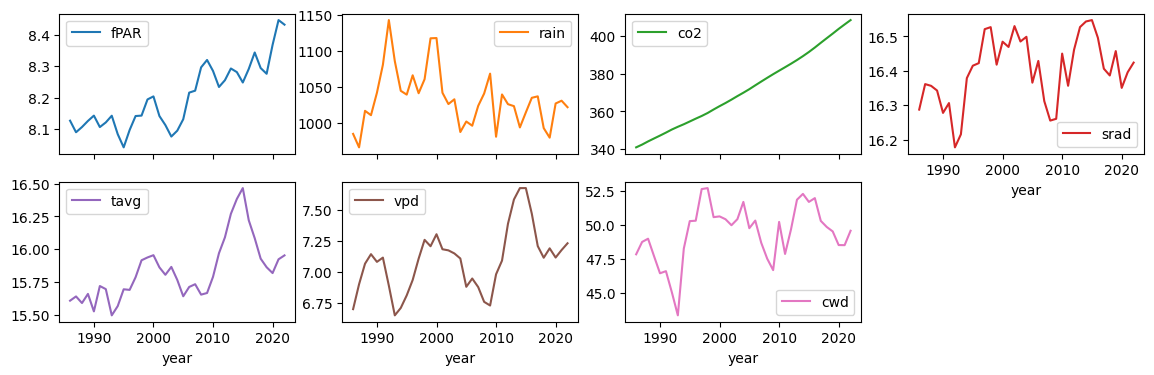

In [10]:
df.plot(subplots=True, layout=(2,4), figsize=(14,4));

### Iterate linear models and plot

0.008003342616093641 0.008417484444093966


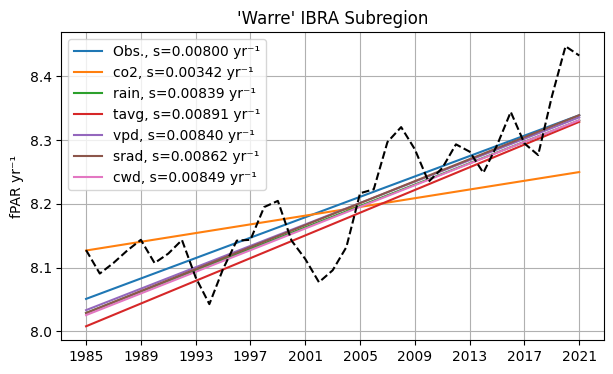

In [12]:
#first fit a model with all vars
x = df[['co2','rain', 'tavg', 'vpd', 'srad', 'cwd']]
y = df['fPAR']

lr = PLSRegression().fit(x, y)
prediction = lr.predict(x)
r2_all = r2_score(y, prediction)

#calculate slope of predicted variable with all params
result = mk.original_test(y, alpha=0.1) #
s_actual = result.slope
i_actual = result.intercept

result_pred = mk.original_test(prediction, alpha=0.1) #
s_prediction = result_pred.slope

fig,ax=plt.subplots(1,1, figsize=(7,4))
y_vals = result.intercept + result.slope *range(0,len(x.index))
ax.plot(range(0,len(x.index)), y_vals, label=f'Obs., s={s_actual:0.5f} yr\u207B\u00B9')

# now fit a model without a given variable
# and calculate the slope of the phenometric
r_delta={}
s_delta={}
for v in ['co2','rain', 'tavg', 'vpd', 'srad', 'cwd']:
    #set variable as constant 
    # constant = x[v].mean()
    constant = x[v][0:1].mean()
    xx = x.drop(v, axis=1)
    xx[v] = constant

    #model and determine slope
    lrr = PLSRegression().fit(xx, y)
    pred = lrr.predict(xx)
    r2 = r2_score(y, pred)
    resulty = mk.original_test(pred, alpha=0.1) #
    s_p = resulty.slope
    
    # plt.plot(y.values, label='Real')
    y_vals = resulty.intercept + resulty.slope *range(0,len(x.index))
    ax.plot(range(0,len(x.index)), y_vals, label=f'{v}, s={s_p:0.5f} yr\u207B\u00B9')
    
    s_delta[v] = math.dist((s_prediction,), (s_p,))
    r_delta[v] = math.dist((r2_all,), (r2,))

ax.plot(y.values, c='black', linestyle='--')
ax.legend()
ax.set_xticks(ticks = range(0,40, 4), labels=range(1985,2022, 4))
ax.set_ylabel('fPAR yr⁻¹')
ax.set_title(f"'{k}' IBRA Subregion")
ax.grid()

s_delta = pd.Series(s_delta)
r_delta = pd.Series(r_delta)
sensivity = pd.concat([s_delta, r_delta], axis=1).rename({0:'Slope_difference', 1:'r2_difference'}, axis=1)

fig.savefig(f'/g/data/os22/chad_tmp/Aus_CO2_fertilisation/results/figs/delta_slope_methods_example.png',
            bbox_inches='tight', dpi=300)